[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/towardsai/ai-tutor-rag-system/blob/main/notebooks/Evaluating_and_Iterating_Prompts.ipynb)

### Installing Necessary packages

In [ ]:
!pip install -q openai==1.107.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/951.0 kB ? eta -:--:--
   ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/951.0 kB 9.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 942.1/951.0 kB 17.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 951.0/951.0 kB 13.1 MB/s eta 0:00:00


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
# Set the following API Keys in the Python environment. Will be used later.
# os.environ["OPENAI_API_KEY"] = "<YOUR_OPENAI_KEY>"


# from google.colab import userdata
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')


True

In [2]:
# Allows running asyncio in environments with an existing event loop in the notebook

import nest_asyncio

nest_asyncio.apply()

### Response Generation Using GPT-5

In [3]:
from openai import OpenAI
client = OpenAI()

In [4]:
prompt_generation = """
Generate a table with the 5 most popular pharmaceutical companies and their foundation years.
The response should include only the table, with no additional text.
Use the following example format:
---
Company | Foundation Year
Microsoft | 1975
Apple | 1976
Google | 1998
Amazon | 1994
Meta | 2004
---"""


# Making the API call
response = client.responses.create(
  model="gpt-5",
  instructions="You are a helpful assistant.",
  input=prompt_generation,
  reasoning={'effort':'minimal'},
)

generated_response = response.output[1].content[0].text
print(generated_response)

Company | Foundation Year
Pfizer | 1849
Johnson & Johnson | 1886
Roche | 1896
Novartis | 1996
Merck & Co. | 1891


### Format Checking with GPT-5 Model (GPT-5 will act as a Judge)

In [5]:
prompt_check_table_new = """Your task is to verify if a given table matches the exact format and structure of a provided example table.

Here's an example of the format that the table should have:
---
Company | Foundation Year
Microsoft | 1975
Apple | 1976
Google | 1998
Amazon | 1994
Meta | 2004
---

Table to Check:
{table_to_check}

Instructions:
- The table to check should match the structure, headers, and format of the Example Table exactly.
- The column names must be "Company" and "Foundation Year".
- The values in each row should have the company names and their corresponding foundation years.
- If the given table matches the example table in all these aspects, write "Yes".
- Write "No" if there are any differences in structure, headers, or if any company/year is missing or incorrect.

Only respond with "Yes" or "No".

"""

formatted_input = prompt_check_table_new.format(table_to_check=generated_response)

# from IPython.display import Markdown, display
# display(Markdown(formatted_input))
print(formatted_input)

Your task is to verify if a given table matches the exact format and structure of a provided example table.

Here's an example of the format that the table should have:
---
Company | Foundation Year
Microsoft | 1975
Apple | 1976
Google | 1998
Amazon | 1994
Meta | 2004
---

Table to Check:
Company | Foundation Year
Pfizer | 1849
Johnson & Johnson | 1886
Roche | 1896
Novartis | 1996
Merck & Co. | 1891

Instructions:
- The table to check should match the structure, headers, and format of the Example Table exactly.
- The column names must be "Company" and "Foundation Year".
- The values in each row should have the company names and their corresponding foundation years.
- If the given table matches the example table in all these aspects, write "Yes".
- Write "No" if there are any differences in structure, headers, or if any company/year is missing or incorrect.

Only respond with "Yes" or "No".




In [6]:
# using LLM as a Judge to check the format
response = client.responses.create(
  model="gpt-5",
  instructions="You are a strict judge. Evaluate inputs based on the given criteria and provide only the required response",
  input=formatted_input,
  reasoning={'effort':'minimal'},
)
print(response.output[1].content[0].text)

Yes


In [7]:
print(formatted_input)

Your task is to verify if a given table matches the exact format and structure of a provided example table.

Here's an example of the format that the table should have:
---
Company | Foundation Year
Microsoft | 1975
Apple | 1976
Google | 1998
Amazon | 1994
Meta | 2004
---

Table to Check:
Company | Foundation Year
Pfizer | 1849
Johnson & Johnson | 1886
Roche | 1896
Novartis | 1996
Merck & Co. | 1891

Instructions:
- The table to check should match the structure, headers, and format of the Example Table exactly.
- The column names must be "Company" and "Foundation Year".
- The values in each row should have the company names and their corresponding foundation years.
- If the given table matches the example table in all these aspects, write "Yes".
- Write "No" if there are any differences in structure, headers, or if any company/year is missing or incorrect.

Only respond with "Yes" or "No".




In [8]:
# Example Badly Formatted Table

badly_formatted_table = """
Company | Foundation Year

Microsoft | 1975

Apple | 1976
Google | 1998
Amazon | 1994

Meta | 2004
"""

In [12]:
# using LLM as a Judge to check the format
response = client.responses.create(
    model="gpt-5",
    instructions="You are a strict judge. Evaluate inputs based on the given criteria and provide only the required response",
    input=formatted_input,
    reasoning={"effort": "minimal"},
)
print(response.output[1].content[0].text)


No


Ask for an explanation of why the input is valid or invalid, providing the required response at the end.

In [11]:
formatted_input = prompt_check_table_new.format(table_to_check=badly_formatted_table)


# using LLM as a Judge to check the format
response = client.responses.create(
  model="gpt-5",
  instructions="You are a strict judge. Evaluate inputs based on the given criteria, explain in detail why the input is valid or invalid, providing the required response at the end.",
  input=formatted_input,
  reasoning={'effort':'medium'},
)
print(response.output[1].content[0].text)

Evaluation:
- Headers: Correct ("Company | Foundation Year").
- Row content and order: Correct (Microsoft 1975; Apple 1976; Google 1998; Amazon 1994; Meta 2004).
- Format/structure: Does not match exactly. The example has contiguous lines with no blank lines between header and rows. The table to check contains extra blank lines after the header, after "Microsoft | 1975", and before "Meta | 2004".

Because the format is not an exact match, the table fails the criteria.

No


### SEE HOW INSTRUCTIONS HAVE CHANGED OUTPUT ABOVE ASKING NOT ONLY FOR VALIDITY ("YES" or "NO") BUT ALSO FOR EXPLANATION

### GPT-5 Acting as a Judge to check the company types (Pharmacitical or not)

In [13]:
prompt_check_company_type = """
Your task is to verify if a given table contains only companies from the pharmaceutical industry.

Here's an example of the format that the table should have:
---
Company | Foundation Year
Microsoft | 1975
Apple | 1976
Google | 1998
Amazon | 1994
Meta | 2004
---

Here's the table to check:
{table_to_check}

Instructions:
- The table to check should include only companies from the pharmaceutical industry.
- The column names will be "Company" and "Foundation Year".
- Evaluate whether each company in the table is part of the pharmaceutical sector.
- If all companies in the table are from the pharmaceutical industry, write "Yes".
- Write "No" if any company in the table is not from the pharmaceutical industry.

Only respond with "Yes" or "No".

"""

In [14]:
formatted_input_company_type = prompt_check_table_new.format(table_to_check=generated_response)

# API Call
response = client.responses.create(
  model="gpt-5",
  instructions="You are a strict judge. Evaluate inputs based on the given criteria and provide only the required response",
  input=formatted_input_company_type,
  reasoning={'effort':'minimal'},
)
print(response.output[1].content[0].text)

Yes


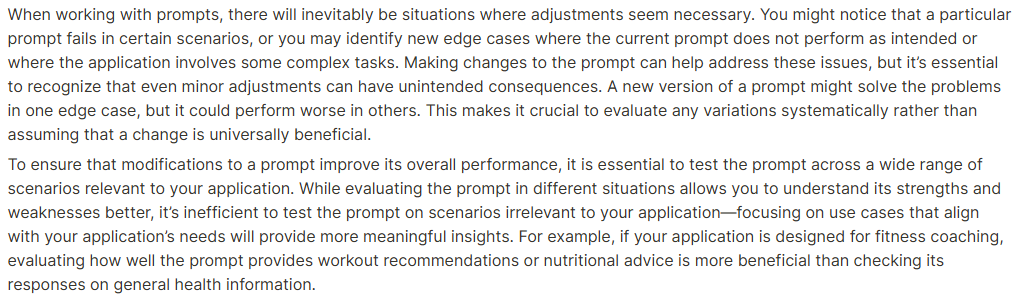

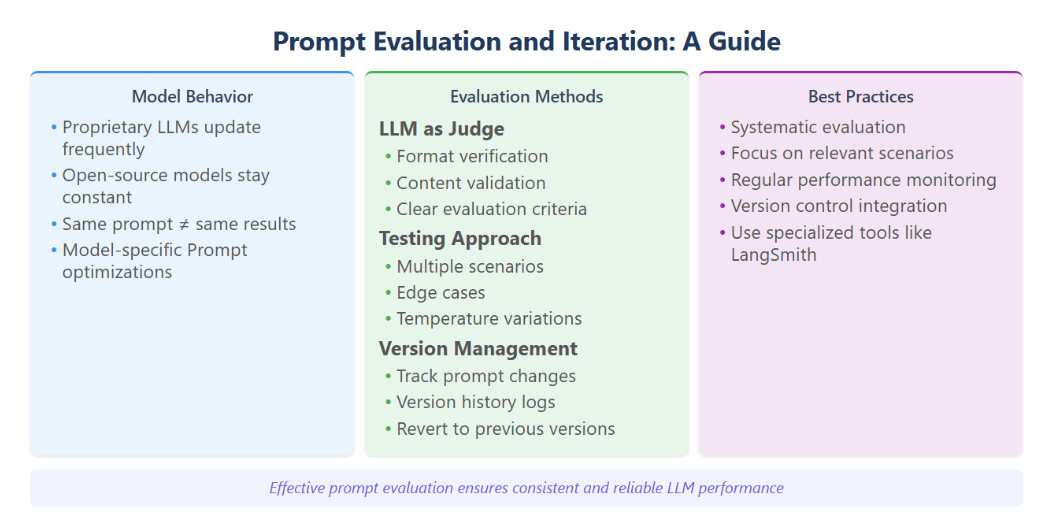

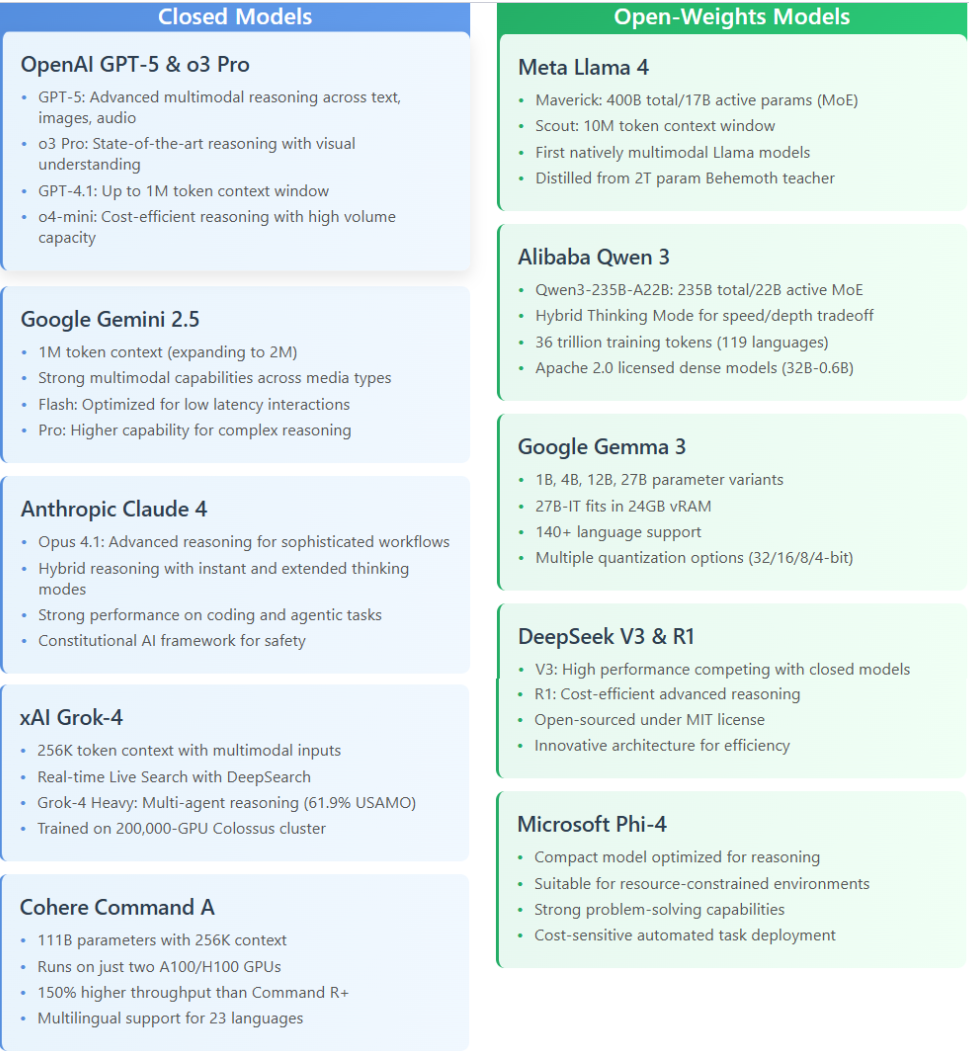

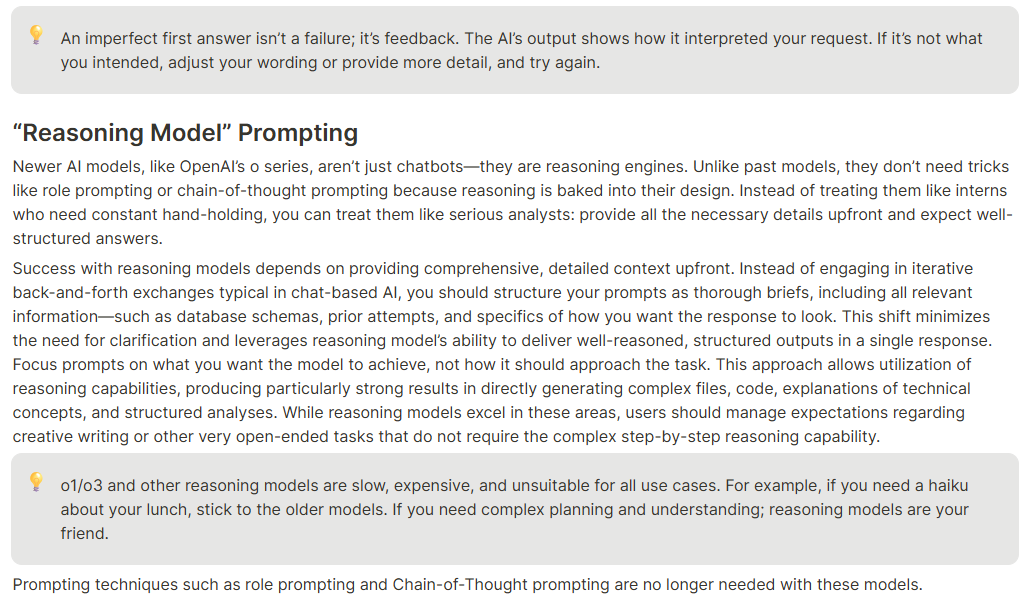

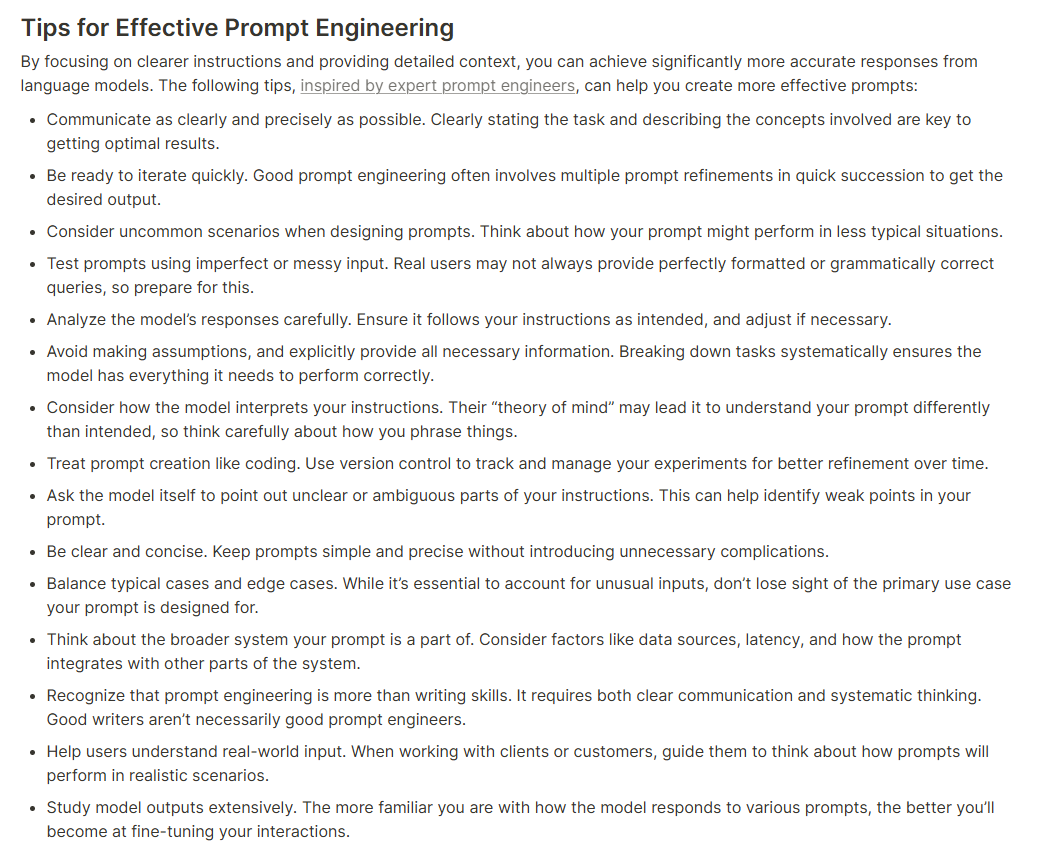

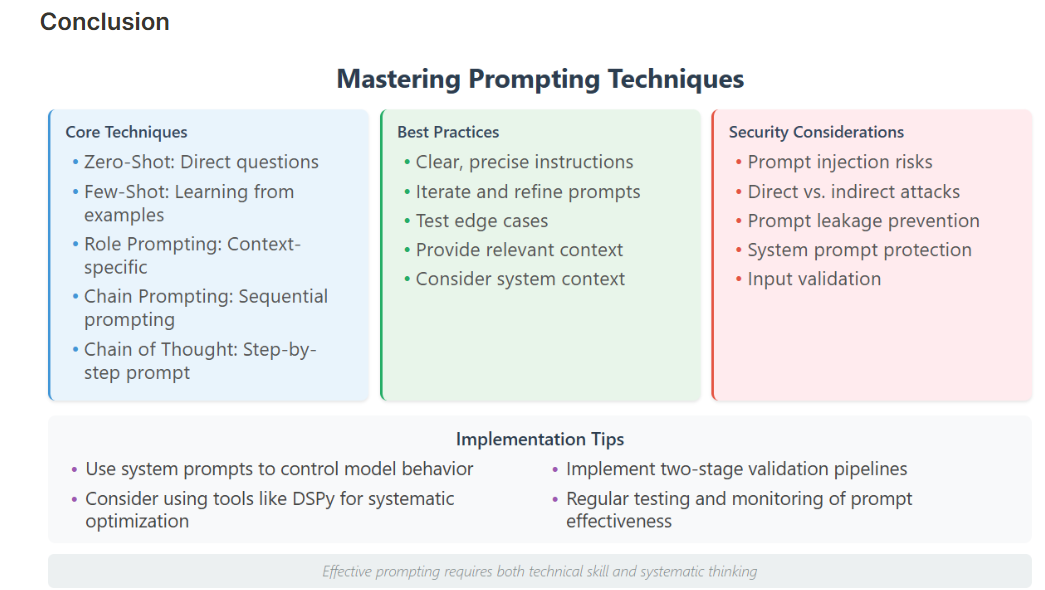